# Used libraries
For the given task, the code must be run in Python 3.6 with the following libraries.

In [1]:
import os
import pandas as pd
from scipy import stats
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


# Inspection of data, multicollinearity and zero variance features


In [2]:
def load_data(filename):
    """
    It loads the data from the csv file to a pandas Dataframe.
    The data column is transformed to datetime, set as index
    and sorted.
    :param filename: str
    :param feature_time: bool
    :return: pandas Dataframe
    """
    parent_dir = os.getcwd()
    df = pd.read_csv(os.path.join(parent_dir, filename))
    df.set_index(["date"], inplace=True)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True, ascending=True)

    return df

In [3]:
filename_train = 'data_train.csv'
filename_weather = 'weather.csv'
df_train = load_data(filename=filename_train)
df_weather = load_data(filename=filename_weather)


The time covered by the training dataset ranges from 2005-03-20 to 2009-12-31, with some missing days 2005-12-26, 2006-12-26, 2007-12-26, 2008-12-26, 2009-12-26. 
The time covered by the weather data ranges from 2005-03-20 to 2010-12-31 with the following missing days: 2005-12-26, 2006-12-26, 2007-12-26, 2008-12-26,  2009-12-26, 2010-11-29, 2010-12-26.


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1743 entries, 2005-03-20 to 2009-12-31
Data columns (total 14 columns):
bank_holiday      1743 non-null int64
feature_0         1743 non-null int64
feature_1         1743 non-null int64
feature_2         1743 non-null int64
feature_3         1743 non-null float64
feature_4         1743 non-null float64
feature_5         1743 non-null float64
feature_6         1743 non-null float64
feature_7         1743 non-null int64
school_holiday    1743 non-null int64
feature_8         1743 non-null int64
feature_9         1743 non-null int64
feature_10        1743 non-null int64
label             1743 non-null int64
dtypes: float64(4), int64(10)
memory usage: 204.3 KB


In [5]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2005-03-20 to 2010-12-31
Data columns (total 8 columns):
air_humidity                  2068 non-null float64
air_temperature_daily_max     2064 non-null float64
air_temperature_daily_mean    2073 non-null float64
air_temperature_daily_min     2063 non-null float64
precipitation                 2106 non-null float64
snow_height                   2106 non-null int64
sunshine_hours                2065 non-null float64
wind_speed_max                2063 non-null float64
dtypes: float64(7), int64(1)
memory usage: 148.1 KB


In [6]:
# day difference between consecutive datetime index for train data
diff_day_train = df_train.index.to_series().diff().dt.days > 1
print(diff_day_train.loc[diff_day_train == True])

date
2005-12-26    True
2006-12-26    True
2007-12-26    True
2008-12-26    True
2009-12-26    True
Name: date, dtype: bool


In [7]:
# day difference between consecutive datetime index for weather data
diff_day_weather = df_weather.index.to_series().diff().dt.days > 1
print(diff_day_weather.loc[diff_day_weather == True])

date
2005-12-26    True
2006-12-26    True
2007-12-26    True
2008-12-26    True
2009-12-26    True
2010-11-29    True
2010-12-26    True
Name: date, dtype: bool



From the training dataset we have the following features:
- Dependent variable: ‘label’

The dependent variables form the training and weather’s features are plotted


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1990465940>,
      dtype=object)

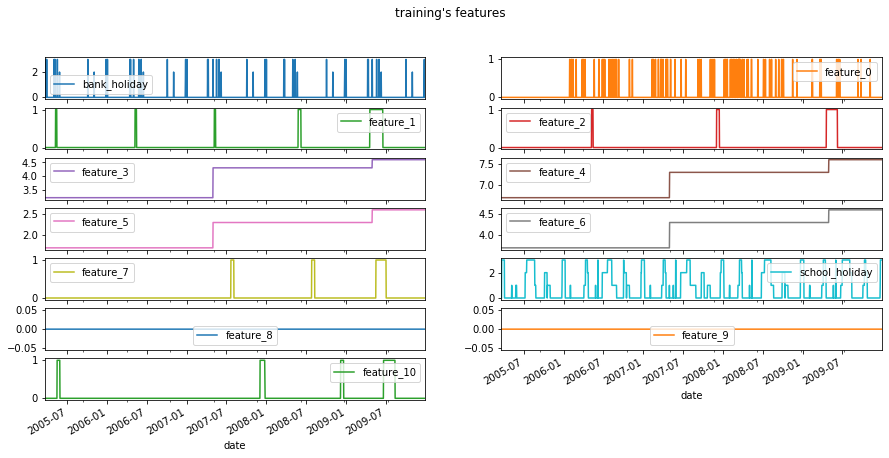

In [8]:
# visualisation of train features
df_train.drop(columns='label').plot(subplots=True,
              layout=(int(df_train.shape[1]/2), 2),
              figsize=(15, 7),
              title="training's features")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19791f7a90>,
      dtype=object)

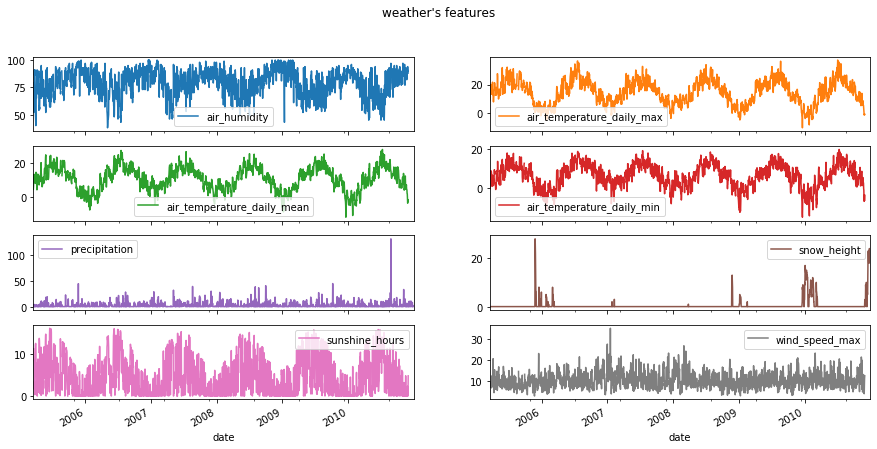

In [9]:
# visualisation of weather features
df_weather.plot(subplots=True,
              layout=(int(df_weather.shape[1]/2), 2),
              figsize=(15, 7),
              title="weather's features")


For the training features, we know that feature_0, feature_1,  feature_2, feature_7, feature_10 can be either binary or one-hot encoded features, whereas bank_holiday and school_holiday is known to be categorical features converted to numerical features; feature_8 and feature_9 are eliminated because of absence of variation in the data (zero variance).



In [10]:
# dropping columns which no variance
df_train = df_train.loc[:, df_train.var() != 0.0]


Furthermore feature_3, feature_5, feature_4 and feature_6 result to be highly correlated (Person correlation > 0.9): if the linear regression is the chosen model then the multicollinearity must be controlled because, although it doesn’t reduce the reliability of the model (its prediction power), it can’t say which collinear predictors are redundant with respect to others. Irrespective of the model, those features which share a really high correlation have been eliminated because of the conveyed redundant information. 


In [11]:
# eliminate collinearity for correlation between features > .90
df_train[['feature_3', 'feature_5', 'feature_4', 'feature_6']].corr(method='pearson')
df_train.drop(columns=["feature_4", "feature_5",
                       "feature_6"], inplace=True)

df_weather[['air_temperature_daily_max',
            'air_temperature_daily_mean',
            'air_temperature_daily_min']].corr(method='pearson')
df_weather.drop(columns=["air_temperature_daily_max",
                         "air_temperature_daily_min",
                         ], inplace=True)


# Missing values
If a feature is composed by more than 20% of missing values, it will be excluded from the dataset. Missing values have bene seen only for the weather data, but not for the training data. In particular for the weather data, only for the features:  air_humidity (2068), air_temperature_daily_mean (2073), sunshine_hours (2065), wind_speed_max (2063)

The first approach has been to remove the rows from the weather data which contained NULL values in the specific feature in the percetage of <0.02. For the rest a linear interpolation has been calculated. This method with dealing has been abandoned because it lowered the prediction power of the model.

The second applied method was to calculate the linear interpolation to all the NULL values in the dataset, calculating the mean between the value before the missing data and the value after.


In [12]:
missing_values_df = df_weather[df_weather.isna().any(axis=1)]
print("percentage of missing values:\n", missing_values_df.sum()/len(df_weather))

# drop rows with NULL values from the dataset if the percentage of missing values is below 0.02
# for col in missing_values_df:
#     if (missing_values_df[col].sum()/len(df_weather)) <= 0.02:
#         df_weather.dropna(inplace=True, axis=0)
#     else:
#         df_weather[col].interpolate(method="linear", inplace=True)

df_weather.interpolate(method="linear", inplace=True)

percentage of missing values:
 air_humidity                  0.320513
air_temperature_daily_mean    0.078965
precipitation                 0.068186
snow_height                   0.163343
sunshine_hours                0.016572
wind_speed_max                0.013153
dtype: float64



# Univariate detection of outliers
Excluding from training data the independent categorical features, only the feature_3 remains which results not to have outliers.


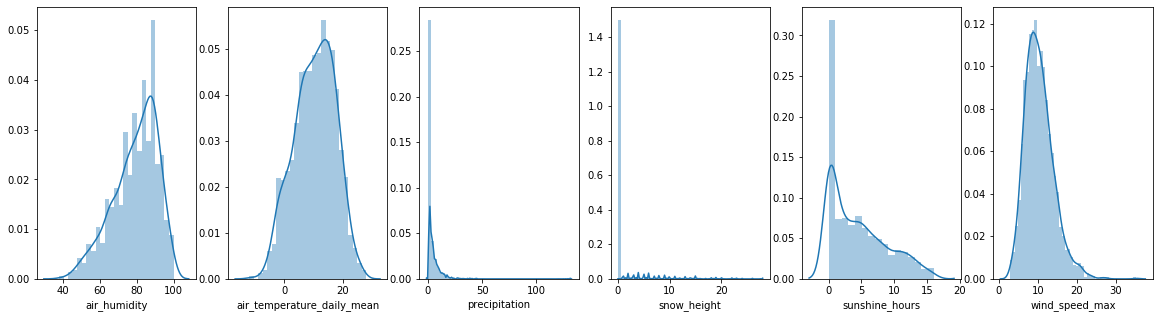

In [13]:
# plotting the distribution of data and the estimated PDF over the data
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, figsize=(20,5))
list_ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for idx, col in enumerate(df_weather):
    sn.distplot(df_weather[col], ax=list_ax[idx])


As we see from the picture above, the distribution of the weather’s features don’t look to normally distributed. For this reason the Interquartile Range or IQR for detection of outliers.
The box-and-whisker plot below shows how the data are distributed by quantiles for the weather data. IQR has been calculated for each feature, which is the range between the first and the third quartiles (the edges of the box) (median is represented by the middle line in the box). 


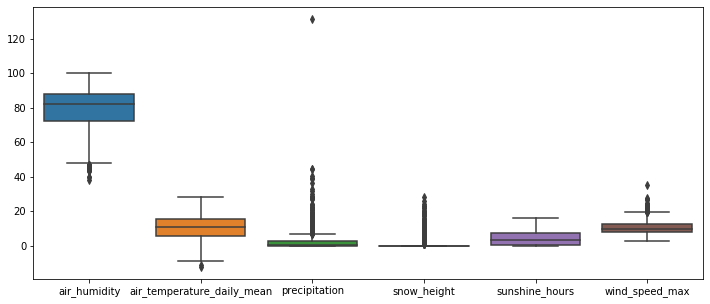

In [14]:
plt.figure(figsize=(12,5))
sn.boxplot(data=df_weather)


The outliers are represented by the rhombus at the low and high end of the whiskers. For the sunshine_hours no outlier is detected. The feature snow_height seems to be really noisy and therefore the percentage of outliers in the feature data has been calculated, which results in less then 0.01%


In [15]:
def outlier2nan(df):
    """
    Detection of outliers by IQR and the linear interpolation
    is calculated.
    :param df: pandas Dataframe
    :return: pandas Dataframe
    """
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        bad_idx = df.index[(df[col] < (Q1 - 1.5 * IQR)) |
               (df[col] > (Q3 + 1.5 * IQR))]
        df.loc[(df.index >= bad_idx.min())
                   & (df.index < bad_idx.max()), col].interpolate(method="linear", inplace=True)

        return df


The outliers have been imputed by a linear interpolated.
The detection and imputation of outliers has been skipped from the final version of the analysis because the prediction power of final model, which is tree-based and thus quite robust to outliers, has resulted to be higher without the imputation of outliers. 



In [16]:
# df_weather=outlier2nan(df=df_weather)

# Feature creation

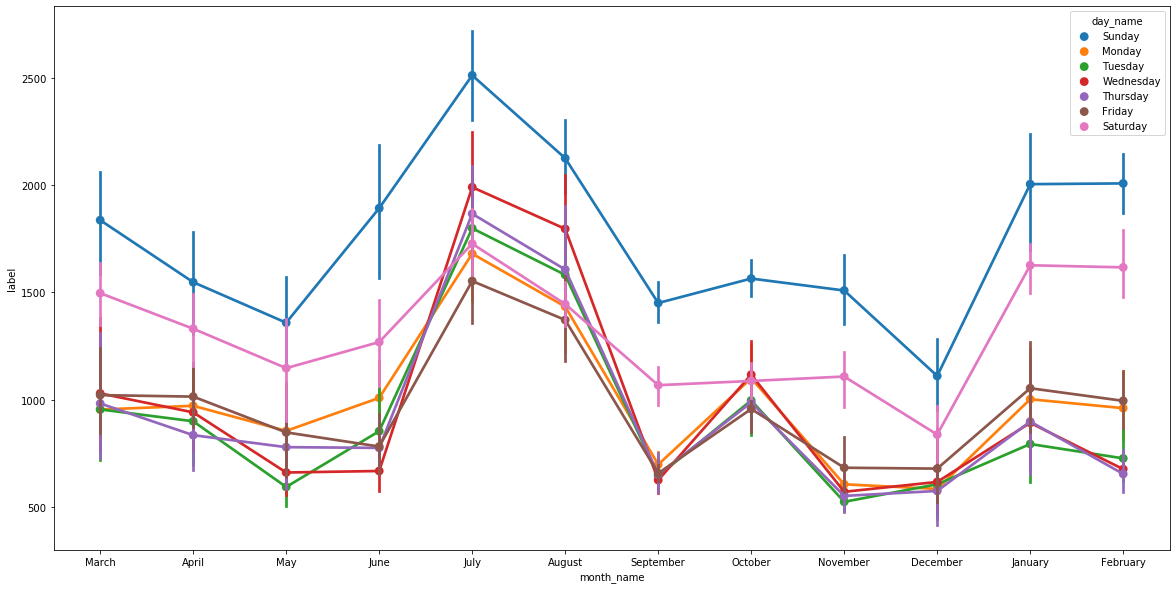

In [17]:
# join the two pandas Dataframe in one
df_total = df_train.join(df_weather, how="inner", sort=True)

# numerical value of the month within a year
df_total["month"] = df_total.index.month
# numerical value of the day within a year
df_total["day"] = df_total.index.day

# visualization of visitors at the leisure attraction
# for month and day of the week
df_total['month_name'] = df_total.index.month_name()
df_total['day_name'] = df_total.index.day_name()
fig, ax = plt.subplots(figsize=(20,10))
sn.pointplot(data=df_total[['month_name', 'label', 'day_name']],
            x='month_name', y='label',
            hue='day_name', ax=ax)
df_total.drop(columns=['month_name', 'day_name'], inplace=True)


Based on the pictures above, where the number of visitors at the leisure attraction is displayed for each month (x-axis) and for different week days (colored lines), some patterns in the data can be seen which justify the creation of some features:



## Features included in the final version of the model: 
- Feature month: since the number of visits changes across months independently of week days, the numeric value corresponding to the month’s year has been added to the data as feature.
- Feature day and weekend: since the number of visits changes across days, in particular for the weekend, the numerical value of the week day is added to the data but also a binary feature for the weekend, which is identified by Saturday and Sunday (Saturday/Sunday = 1, Monday/Tuesday/ Wednesday/Thrusday/Friday = 0). Friday is not included in the weekend because since we have seen that the school_holiday highly correlates with the dependent variable, it is inferred that the leisure attraction is mostly probably for children and for this reason it is less populated during school days. 
- Feature summer: as shown in the graph, in the month of June, July and August there is an overall increase in the visits at the leisure attraction. For this reason a binary feature has been added (June, July and August = 1, rest of the year’s months = 0). 
- Feature season: the data shown a diverse number of visits also across seasons and for this reason a numerical value corresponding to the season has been added to the data as feature.


In [18]:
# numerical value of the day within a week
# Monday = 0, Tuesday = 1, Wednesday= 2, Thursday = 3, Friday = 4,
# Saturday = 5, Sunday is 6.
df_total["week_day"] = df_total.index.weekday
# numerical value of the season
df_total['season'] = df_total.month.apply(lambda x: (x%12 + 3)//3)
# binary weekend feature
df_total['is_weekend'] = 0
df_total.loc[(df_total['week_day'] == 5) |
             (df_total['week_day'] == 6), 'is_weekend'] = 1
# binary summer feature
df_total["summer"] = 0
df_total.loc[(df_total['month'] == 6) |
             (df_total['month'] == 7) |
             (df_total['month'] == 8), 'summer'] = 1


## Weather’s features excluded in the final version of the model 

-	Grouping data based on season: each weather’s feature has been grouped by season and the mean value has been calculated. Those new features resulted not to improve the model prediction and therefore they have been excluded from the final version of the analysis.
-	Mean of lag feature with a sliding window of 2 days (for features air_temperature_daily_mean and precipitation): when we make a decision about going somewhere the information of temperature or presence of precipitation in the previous days can play an important role.  For this reason the data for these two features have been shifted of one (a t_1 column) and then the mean is calculated on window of 2 values collected for each time step. This analysis has given any improvement in the model prediction and thus it has been excluded in the final version of the analysis. 


In [19]:
def grouping_by_season(df, list_features):
    """
    For the weather features, the mean is calculated for
    the values grouped by season.
    :param df: pandas Dataframe
    :param list_features: list
    :return: pandas Dataframe
    """
    for col in list_features:
        mean_col = dict(df.groupby('season')[col].mean())
        df['season_mean_'+col] = df['season'].apply(lambda x: mean_col[x])

    return df

In [20]:
# grouping weather features by season
# list_weather_features = ['air_humidity', 'air_temperature_daily_mean', 'precipitation',
# 'snow_height', 'sunshine_hours', 'wind_speed_max']
# df_total = grouping_by_season(df=df_total, list_features=list_weather_features)

In [21]:
def mean_lag_features(df, list_features):
    """
    Created a shifted column for each feature in the list_features.
    For that column the NAN value is imputed with a back-filling method.
    The mean for a sliding window of two values is calculated.
    :param df: pandas Dataframe
    :param list_features: list
    :return: pandas Dataframe
    """
    for col in list_features:
        t_1 = df[col].shift(1)
        t_1.fillna(method='bfill', inplace=True)
        w = t_1.rolling(2).mean()
        df["shift1_mean_" + col] = w

    return df

In [22]:
# Mean of lag feature with a sliding window of 2 days
# list_lag_features = ['air_temperature_daily_mean', 'precipitation']
# df_total=mean_lag_features(df=df_total, list_features=list_lag_features)


In the figure below the scatter plot of the final features are depicted with the target variable. 


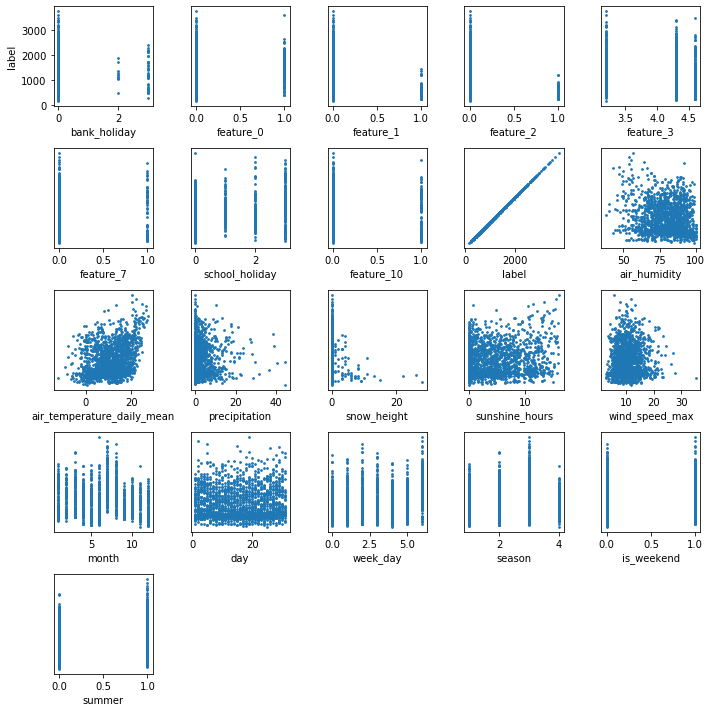

In [23]:
fig = plt.figure(3)
for id, col in enumerate(df_total):
    axi = fig.add_subplot(5, 5, id+1)
    if id+1 > 1:
        axi.axes.yaxis.set_visible(False)
        axi.set_yticklabels([])
    df_total.plot.scatter(x=col, y="label", ax=axi, s=3 , figsize=(10, 10))
fig.tight_layout()

The correlation matrix is shown below. In general we can notice that feature_2 and feature_1 and week_day and is_weekend are correlated (although below 0.9). I decided to keep those features because the type of chosen models, tree-based models, are quite robust to multicollinearity.

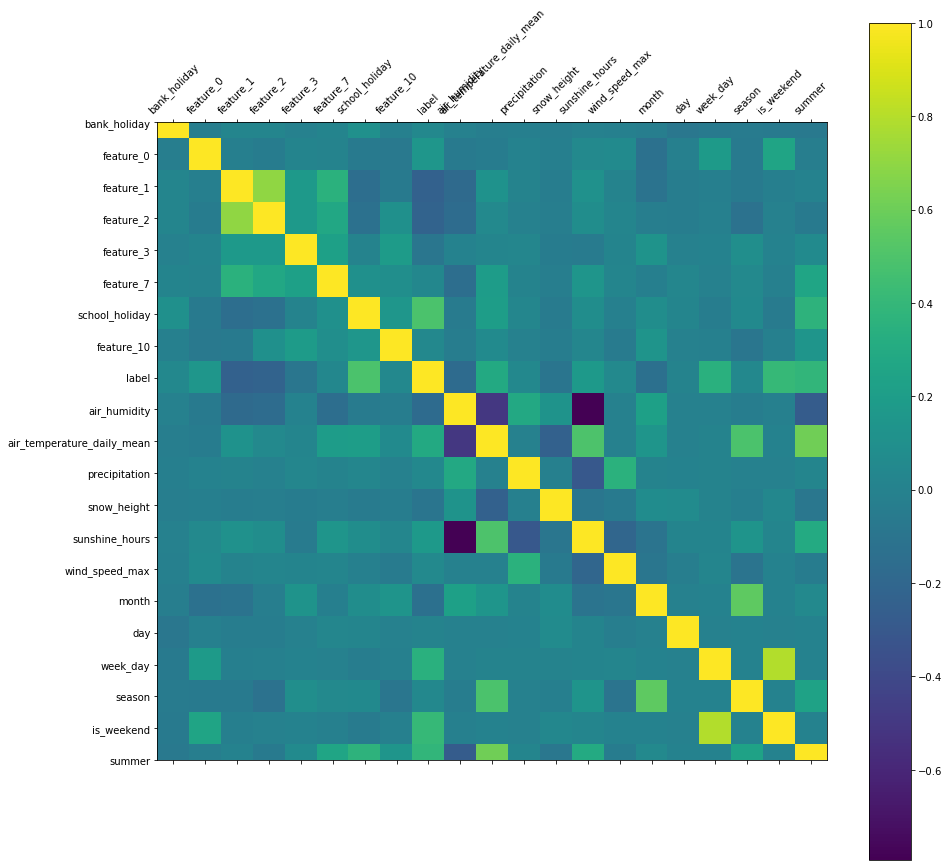

In [24]:
f = plt.figure(figsize=(15, 15))
plt.matshow(df_total.corr(), fignum=f.number)
plt.xticks(range(df_total.shape[1]), df_total.columns, fontsize=10, rotation=45)
plt.yticks(range(df_total.shape[1]), df_total.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

# Model selection
During the research phase of this project similar projects were found. In several studies Decision Tree algorithms have been utilized as classification/regression algorithms to predict the sales in real-life application under different conditions [1, 2], as well as for weather forecasting [3]. The Gradient Boosting is another algorithms that is based on decision tree [4, 5]: when the Gradient Boosting is used to predict continuous value, the it is called Gradient Boosting Regressor. The main idea behind this algorithm is that we start with the average value of the target value; we add a new tree based on the residuals (difference between observed and predicted values) and we scale the tree contribution to the final prediction by the learning rate. We keep adding trees based on the errors made by the previous tree in order to minimize the prediction error. Jain et al., (2015) used the XGboost, an improved method of Gradient Boosting algorithms to forecast sales based on temporal, economical data, but also school and state holidays [6].

An ensemble of randomly trained decision trees make up a random forest. The most important concept of a random forest is that each randomly trained decision is randomly different from another. This is what leads to its great generalization abilities. A class of random forest is represented by the extra tree (also called extreme random forests): the main difference to the random forest is that instead of computing the locally optimal feature/split combination (for the random forest), for each feature under consideration, a random value is selected for the split (for the extra trees). In a project of a bike sharing solution, the goal was to predict how many vehicles many vehicles will be available on a given time of the day, given also some weather conditions: the extra tree regressor resulted to perform better than others (decision tree, gradient boosting trees and random forest) [7]. 

Based on models studied by former researchers, two different machine learning methods, Gradient Boosting Regressor and Extra Tree Regressor were compared these to find the optimal prediction method.

The presence of outliers and possible multicollinearity are both unproblematic for the tree-based models for the following reasons:
1.	Multicollinearity: one of two variables highly correlated will be selected for the tree split and the redundant information conveyed by the second one won’t be included in tree leaves.
2.	Outliers: if there are few outliers in the data, they won’t be relevant for split because each one divides the data into groups based on whether the case is above or below a given threshold value for the feature. 
    
And as result, Gradient Boosting Regressor resulted to perform better for this given type of problem.


# Train-test split
The feature dataset with the target variable has been split in train and test sets with a ratio of 80/20. Furthermore in order to assure that the predictor variables have the same characteristics (distribution) in train and test data. Indeed, if the contrary is true the model would perform well on the training data but it fails to match up to the same performance for the test data. In order to control for this eventuality, a Kolmogorov-Smirnov statistic has been computed for each feature from the train and test data.


In [25]:
def train_test_km(df, target_var, test_size):
    """
    The dataset is split in training and test data based on the test_size
    The Kolmogorov-Smirnov statistics is executed to verify weather the feature
    distributions between train and test are not significantly dissimilar.
    :param df: pandas Dataframe
    :param test_size: float
    :return: numpy array, numpy array, numpy array, numpy array
    """
    Y = df.label.values
    df_ = df.drop(columns=target_var)
    X = df_.values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
                                                        random_state=42)
    # Kolmogorov-Smirnov statistics
    # to check whether the data come from the same distribution
    xtrain = pd.DataFrame(X_train, columns=df_.columns)
    xtest = pd.DataFrame(X_test, columns=df_.columns)
    for col in df_:
        _, pvalue = stats.ks_2samp(xtrain[col], xtest[col])
        if pvalue < 0.05:
            print("For the feature {}, the distributions of train and test"
                  "samples are significantly dissimilar with a p-value of {}."
                  .format(col, str(pvalue)))

    return X_train, X_test, y_train, y_test

In [26]:
# splitting the data in train and test sets
X_train, X_test, y_train, y_test = \
    train_test_km(df=df_total, target_var="label", test_size=0.20)


# Cross-validation
The cross validation with 3 folds has been executed on the training set for the independent and dependent variables on the three proposed prediction models. The mean of coefficient of determinations is calculated across the three folds. The highest average coefficient of determination determines which model is selected. 


In [1]:
# cross-validation
list_scores = []
models = [ExtraTreesRegressor(),
          GradientBoostingRegressor()]

for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='explained_variance', verbose=1)
    list_scores.append(np.mean(scores))
print('highest average explained variance on the training = {}'.format(str(np.max(list_scores))))
chosen_model = models[list_scores.index(np.max(list_scores))]

NameError: name 'ExtraTreesRegressor' is not defined

In [28]:
print(chosen_model)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


# Tuning
For the Gradient Boosting Regressor the tuning concerns tree- and boosting-related parameters. 
For the tree-related paramenters we have :
- max number of features: number of features to consider while deciding for each split
- minimum samples of split: number of samples necessary to allow the tree split
- minumum samples of leaf: number of samples to define a leaf
- max tree depth: max depth to ensure no further split although the minimum sample split has bene reached.

For the boosting-related paramenters:
- learning rate: it decides the impact of the each tree in the final prediction (scaling factor)
- number of estimators: number of modelled trees before the prediction is made
- subsamples: the percentage of samples for each tree (random sampling)

Concerning the loss function, the least squares has been used. Gradient boosting regressors are a type of inductively generated tree ensemble model. At each step, a new tree is trained against the computed negative gradient of the loss function, which in the case of the least squares is 
the negative value of the gradient of loss: -2 * (true_y_value - predicted_y_value).

In [29]:
# param_grid = {'n_estimators': [100, 500, 1000],
#               'learning_rate': [.001, 0.01, .1],
#               'max_depth': [2, 3, 5, 7],
#               'max_features': list(range(1,X_train.shape[1])),
#               'min_samples_leaf': [1, 3, 5, 7, 9],
#               'min_samples_split': [2, 4, 6, 8, 10,
#                                     20, 40, 60, 100],
#               'subsample': [.5, .75, 1],
#               'random_state': [1]}
#
# grid_search = GridSearchCV(estimator=chosen_model,
#                            param_grid =param_grid,
#                            cv=3,
#                            n_jobs=-1,
#                            verbose=1)
# grid_search.fit(X_train, y_train)
# predictions = grid_search.predict(X_test)
# print('RMSE = {}'.format(str(sqrt(mean_squared_error(y_test, predictions)))))
# print('explained variance on the test after tuning = {}'
#       .format(str(explained_variance_score(y_test, predictions))))

In [30]:
tuned_model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=7,
                          max_features=17, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto', random_state=1,
                          subsample=0.5, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

tuned_model.fit(X_train, y_train)
predictions_tuned = tuned_model.predict(X_test)
print('RMSE = {}'.format(str(sqrt(mean_squared_error(y_test, predictions_tuned)))))

RMSE = 232.80084203561324


# Feature importance

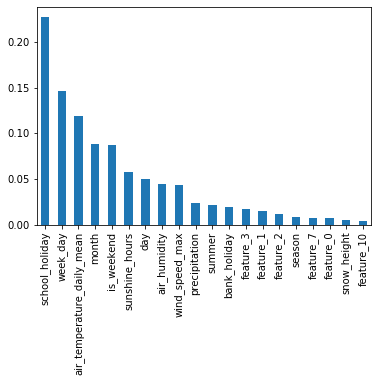

In [31]:
important_features = pd.Series(data=tuned_model.feature_importances_,
                               index=df_total.drop(columns='label').columns.values)
important_features.sort_values(ascending=False, inplace=True)
important_features.plot(kind='bar')

# Comparision to baseline approach
For the task a baseline value of the Root Mean squared Error was 500. With the above described anaylsis the Mean squared Error has reduced to 231 with 86.7% of explained variance.
Below a short description of improvements made by the developed analysis is provided:

1.	Elimination of redundant or useless features: the features which correlate r > .90 are elimnated, but also those which don't show any variation in the data. 

2.	Missing values have been imputed by linear interpolation, assuring that the missing point is filled with the mean value between the two nearest points.

3.	Feature creation: one crucial step in the analysis improvement is represented by the creation of new features which could account for most of the target variable's variance.

4.	Model selection: if the linear regression is assumed to be the baseline approach, the performance of the Boosting Gradient resulted to be better for different reasons:

    - multicollinearity: in oder to apply a linear regression model several assumptions must be met in the data, including the absense of collinearity between independent variables.
    - outliers: in a linear regression, the outliers are especially important because they can have a strong inﬂuence on the least squares line. This problem does not concern much the tree-based models.
    - non-linear relationships: unlike linear models, the boosted trees model are able to capture non-linear interaction between the features and the target.

For this task I needed in total around 13 hours, a bit more than the suggested amount.

# References 

[1] Thomassey, S. (2010). Sales forecasts in clothing industry: The key success factor of the supply chain management.

[2] Thomassey, S., & Fiordaliso, A. (2006). A hybrid sales forecasting system based on clustering and decision trees.

[3] Kumar, Rajesh. (2013). Decision Tree for the Weather Forecasting.

[4] Friedman, J. H. (2002). Stochastic gradient boosting.

[5] A Kaggle Master Explains Gradient Boosting. (2017, January 24). Retrieved December 08, 2017, from http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

[6] Jain, A.K., Menon, M.N., & Chandra, S. (2015). Sales Forecasting for Retail Chains.

[7] Vallantin L. (2018), Predicting bike sharing trends with Python. From https://medium.com/@limavallantin/analysing-bike-sharing-trends-with-python-a9f574c596b9
